#Implementação em GPU - CUDA

*Moniele Kunrath Santos*

<br>
CUDA (anteriormente conhecido como Compute Unified Device Architecture ou Arquitetura de Dispositivo de Computação Unificada) é uma API destinada a computação paralela, GPGPU, e computação heterogênea, criada pela Nvidia. destinada a placas gráficas que suportem a API (normalmente placas gráficas com chipset da Nvidia). A plataforma CUDA dá acesso ao conjunto de instruções virtuais da GPU e a elementos de computação paralela, para a execução de núcleos de computação. 

Para a tarefa utilizei o algoritmo que percorre todos os pixels de todos os canais de cores [2] (imagem da célula abaixo), onde notamos que:

 

```
# grayPixel[I,J] = 0.21*r + 0.71*g + 0.07*b
```
[1] https://pt.wikipedia.org/wiki/CUDA
<br>
[2] https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale


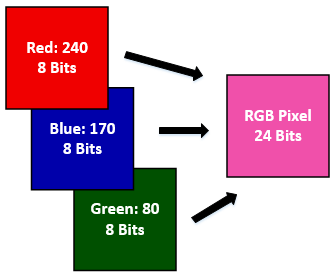

Imagem 1

##Status da GPU


In [99]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [100]:
%%script bash

nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


#Transformando Imagem RGB em Imagem Escala de Cinza


In [101]:
#Utilizando biblioteca fornecida importada do GitHub. Direitos autorais do user @nothings de email sean+github@nothings.org.

!git clone https://github.com/nothings/stb

fatal: destination path 'stb' already exists and is not an empty directory.


In [102]:
#Baixando a imagem a ser utilizada no experimento

!wget -O lena.png https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRiuE1n928su4cDZy3IcUURmGsvVxzfc8i4lQ&usqp=CAU

--2020-12-01 01:44:26--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRiuE1n928su4cDZy3IcUURmGsvVxzfc8i4lQ
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.217.164.174, 2607:f8b0:4004:815::200e
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.217.164.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8209 (8.0K) [image/jpeg]
Saving to: ‘lena.png’

lena.png            100%[===================>]   8.02K  --.-KB/s    in 0s      

2020-12-01 01:44:26 (67.9 MB/s) - ‘lena.png’ saved [8209/8209]



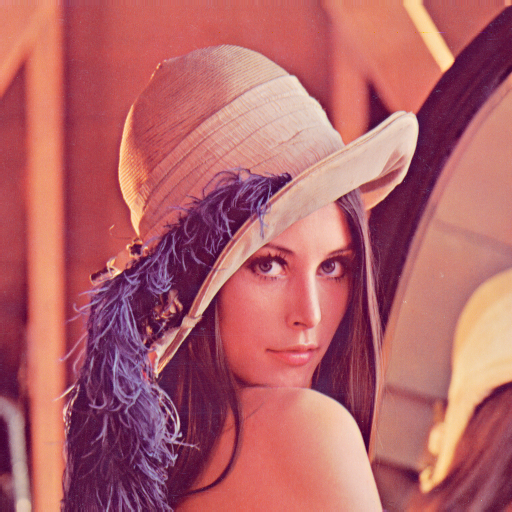



In [117]:
%%writefile rgbToGray.cu
#define CHANNELS 4 // define os canais da img RGB png==4 e jpg==3

#define STB_IMAGE_IMPLEMENTATION
#include "stb/stb_image.h" //imread
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h" //imwrite

__global__ void toGray(uint8_t * grayImage, 
    uint8_t * rgbImage, int width, int height) {

    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    if (x < width && y < height) {
    // pega coordenada 1d para a img grayscale
        int grayOffset = y*width + x;
        int rgbOffset = grayOffset*CHANNELS;

        unsigned char r = rgbImage[rgbOffset ]; // valor red
        unsigned char g = rgbImage[rgbOffset + 2]; // valor green
        unsigned char b = rgbImage[rgbOffset + 3]; // valor blue
        // reescala e salva
        // Multiplica pelas constantes
        grayImage[grayOffset] = 0.21f*r + 0.71f*g + 0.07f*b;
    }

}

int main(void){
    
    // x = linhas; y = colunas
    int x,y,n;
    
    // carregando imagem com a bioblioteca importada
    uint8_t *data = stbi_load("lena.png", &x, &y, &n, CHANNELS);
    int size = x * y;

    // alocando mem para ponteiro da matriz colorida que será manipulado dentro da func toGray() 
    uint8_t * rgb_cuda;
    cudaMalloc(&rgb_cuda, CHANNELS * size * sizeof(uint8_t));

    // copiando img para o ponteiro cuda
    cudaMemcpy(rgb_cuda, data,CHANNELS *size, cudaMemcpyHostToDevice);

    // alocando mem para ponteiro da matriz tons de cinza que será manipulado dentro da func toGray()
    uint8_t * gray_image_cuda;
    cudaMalloc(&gray_image_cuda, size * sizeof(uint8_t));
    
    // ponteiro que recebe o resultado final
    uint8_t * gray_image;

    // inicializando o num de threads e blocos 
    
    //---pedaço de código fornecido pelo colega @Alexandre Thurow Bender
    const int thread = 16;
    const dim3 blockSize(thread, thread, 1);
    const dim3 gridSize(x, y, 1);

    toGray<<<gridSize, blockSize>>>(gray_image_cuda, rgb_cuda, x, y);
    //---

    // copiando do ponteiro cuda para o ponteiro que recebe a img em tons de cinza
    gray_image = (uint8_t *) malloc(size * sizeof(uint8_t));
    cudaMemcpy(gray_image, gray_image_cuda, size, cudaMemcpyDeviceToHost);

    // utiliza funcao para salvar a imagem resultante
    stbi_write_jpg("img_cinza.jpg", x, y, 1, gray_image, 100);

    // libera espaço na memoria
    cudaFree(gray_image_cuda);
    cudaFree(rgb_cuda);
    stbi_image_free(data);
    free(gray_image);

    
    return 0;
}

Overwriting rgbToGray.cu


In [118]:
%%script bash

nvcc rgbToGray.cu -o rgbToGray


stb/stb_image.h(4152): warning: variable "old_limit" was set but never used

stb/stb_image.h(5038): warning: variable "idata_limit_old" was set but never used

stb/stb_image.h(6778): warning: variable "out_size" was set but never used

stb/stb_image.h(6779): warning: variable "delays_size" was set but never used



In [119]:
%%script bash

./rgbToGray

Resultado Da função:

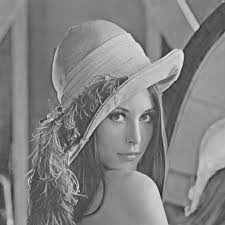